# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Constant, Function, FunctionSpace, Expression
from dolfinx.mesh import create_interval
from constitutive import sat, temp, perm, L, N, Ke, Pi,Sigma,Q
from mpi4py import MPI
from params import nz,phi_max,phi_min, Tf, Tm, z_sc, rho_w,rho_s,g,stress_sc,w_sc,zf,gamma,Tz_sc
from petsc4py import PETSc
from solvers import full_solve, initial_solve
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_movie
from fem_spaces import mixed_space

Define domain:

In [3]:
# generate mesh, initial domain is scaled height of 1 
zl = zf+1
domain = create_interval(MPI.COMM_WORLD,nz,[zf,zl])

Define initial porosity $\phi_0$  and effecive pressure $N=N_f$  at base of fringe

In [4]:
phi0 = 0.5
Nf = 0.1 #Pi(phi0)

Plot saturation, permeability, temperature:

In [5]:
# z =  domain.geometry.x[:,0]

# T = temp(z)
# S = sat(T)
# K = perm(S)

# plt.figure(figsize=(10,6))
# plt.subplot(131)
# plt.plot(S,z)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel(r'$S$',fontsize=20)
# plt.ylabel(r'$z$',fontsize=20)
# plt.subplot(132)
# plt.plot(T,z)
# plt.xticks(fontsize=16)
# plt.yticks([])
# plt.xlabel(r'$\theta$',fontsize=20)
# plt.subplot(133)
# plt.plot(K,z)
# plt.gca().yaxis.set_label_position("right")
# plt.gca().yaxis.tick_right()
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel(r'$k$',fontsize=20)
# plt.ylabel(r'$z$',fontsize=20)
# plt.show()
# plt.close()

Define initial porosity:

In [6]:
V = mixed_space(domain)  # set function space options in fem_spaces.py
initial = Function(V)
initial.sub(2).interpolate(lambda x:phi0+0*x[0])

# define same initial condition function for initial velocity solve
V0 = FunctionSpace(domain, ("CG", 1)) 
phi_0 = Function(V0)
phi_0.interpolate(lambda x:phi0+0*x[0])

Solve the momentum balance for the initial porosity to obtain the initial velocity:

In [7]:
sol,N_ = initial_solve(domain,phi_0,Nf)
initial.sub(0).interpolate(sol.sub(0))
initial.sub(1).interpolate(sol.sub(1))

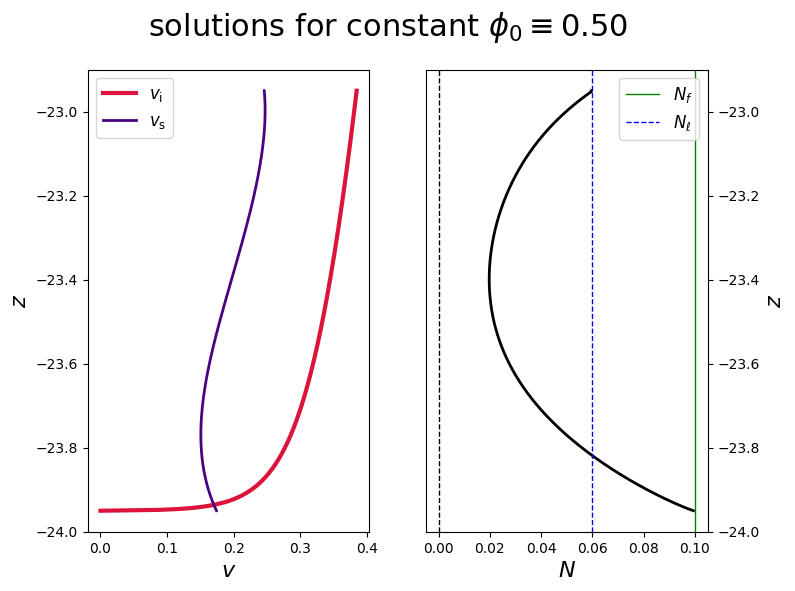

In [8]:
# Plot the solution:


#-------------------------------------------
# plot initial conditions to check ...
z =  SpatialCoordinate(domain)[0]
T = temp(z)



N__ = Function(V0)
N__.interpolate(Expression(N_, V0.element.interpolation_points()))

S = sat(T)

w0 = Function(V0)
wi0 = Function(V0)
w0.interpolate(Expression(sol.sub(0), V0.element.interpolation_points()))
wi0.interpolate(Expression(sol.sub(1), V0.element.interpolation_points()))


Nl_ = (1-phi_0*S)*((1+T) - Sigma(wi0,phi_0,S)/(phi_0*S))
Nl__ = Function(V0)
Nl__.interpolate(Expression(Nl_, V0.element.interpolation_points()))
Nl = Nl__.x.array[-1]

m = Q(phi_0,S)/(1-phi_0*S)
wil = Function(V0)
wil.interpolate(Expression(w0+m, V0.element.interpolation_points()))
wil = wil.x.array[-1]

z_ = domain.geometry.x[:,0]
w_ = w0.x.array
wi_ = wi0.x.array
N_p = N__.x.array

plt.figure(figsize=(8,6))
plt.suptitle(r'solutions for constant $\phi_0\equiv$'+'{:.2f}'.format(phi0),fontsize=22)
plt.subplot(121)
plt.plot(wi_,z_,color='crimson',linewidth=3,label=r'$v_\mathrm{i}$')
plt.plot(w_,z_,color='indigo',linewidth=2,linestyle='-',label=r'$v_\mathrm{s}$')
# plt.axvline(wil,color='k',linestyle='--',linewidth=1,label=r'$v_\mathrm{i}(z_\ell)$ (true)')
plt.xlabel(r'$v$',fontsize=16)
plt.ylabel(r'$z$',fontsize=16)
plt.legend(fontsize=12)
plt.subplot(122)
plt.plot(N_p,z_,color='k',linewidth=2)
plt.axvline(Nf,color='green',linestyle='-',linewidth=1,label=r'$N_f$')
plt.axvline(Nl,color='blue',linestyle='--',linewidth=1,label=r'$N_\ell$')
plt.axvline(0,color='k',linestyle='--',linewidth=1)
plt.xlabel(r'$N$',fontsize=16)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel(r'$z$ ',fontsize=16)
# plt.xlim(0,N_.max())
plt.legend(fontsize=12)
plt.show()
plt.close()

In [9]:
t_0 = 0
t_max = 12
dt0 = t_max/5000

In [10]:
ws,phi, wi, N_, z,sol0,domain0,timesteps = full_solve(domain,initial,Nf,t_0,t_max,dt0)

Time stepping...


Plot:

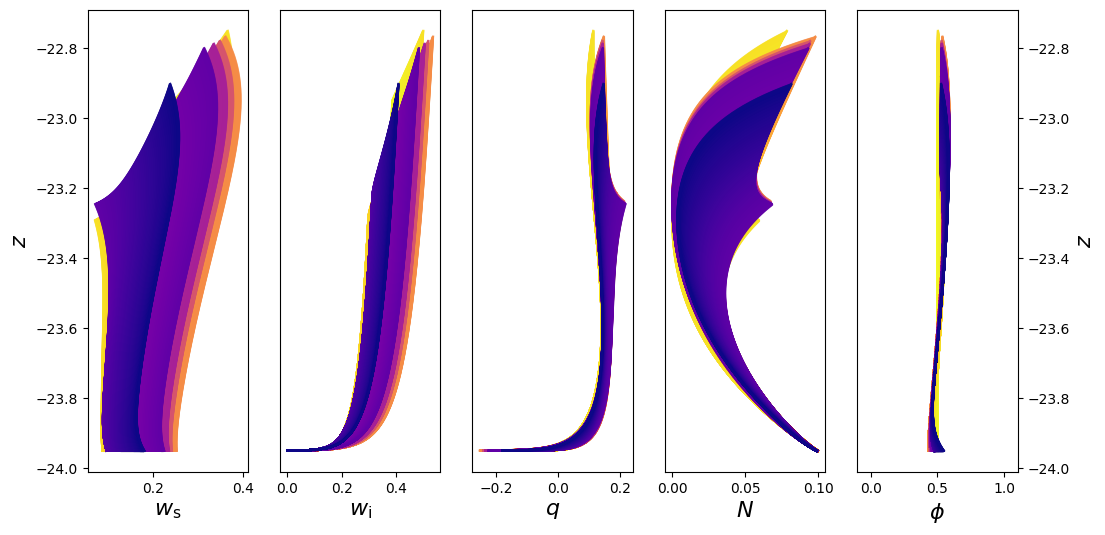

In [14]:
plot(ws,wi,phi,z,N_,timesteps)

Plot movie:

In [21]:
# # plot a movie, but should probably modify the timesteps in
# # the plotting function so it doesn't plot so many and possibly
# # run out of memory in docker 
# plot_movie(ws,wi,phi,z,N_,timesteps)

In [12]:
zl = np.max(z,axis=-1) # lens position

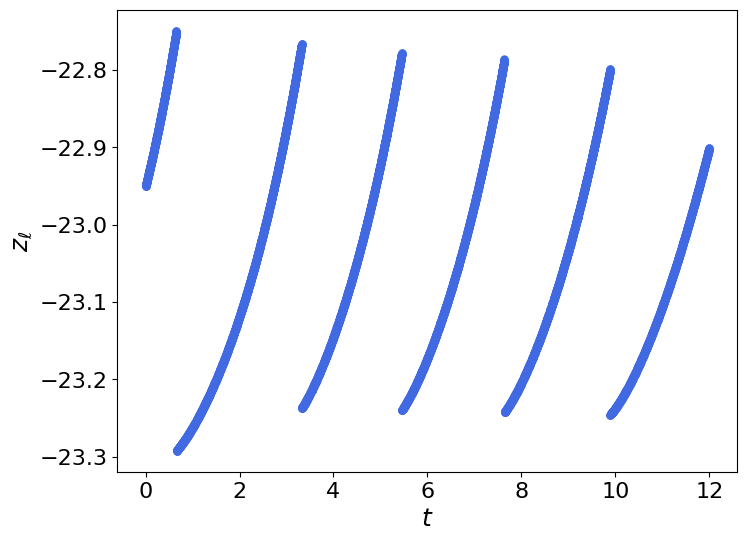

In [13]:
plt.figure(figsize=(8,6))
plt.plot(timesteps,zl,'o',color='royalblue',markersize=5)
plt.xlabel(r'$t$',fontsize=18)
plt.ylabel(r'$z_\ell$',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()
plt.close()